In [1]:
from ebsco_pubs import ebsco_reader as ebsco
from jhu_covid19 import jhu_reader as jhu
from quandl_stocks import quandl_reader as quandl

import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model
import numpy as np

def read_data(ebsco_abs_path, jhu_dir_path, quandl_api_key):
    # Get publication data
    pubs = ebsco.read_data(ebsco_abs_path, "COVID-19");

    # Get covid case data
    covid = jhu.read_data(jhu_dir_path)

    # Get NASDAQ data starting january 1st, 2016 to get good time fixed effects
    nsdq = quandl.read_data(quandl_api_key, start_date = '2016-01-01')

    pubs.index.name = 'Date'
    covid.index.name = 'Date'
    nsdq.index.name = 'Date'
    return covid, pubs, nsdq

def pool_data(covid, pubs, stocks, normalized=False):
    frames = [covid, pubs, stocks]
    result = pd.concat(frames, axis = 1, sort=True).fillna(0)
    
    result['Index Value'] = np.log(result['Index Value'])
    
    if normalized:
        x = result.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        result = pd.DataFrame(x_scaled, columns=result.columns, index=result.index)
    return result
    
def plot_data(covid, pubs, stocks, pool = None):
    # Find which dataset starts latest
    min_date = max(min(covid.index), min(pubs.index), min(stocks.index))
    # Find which dataset ends first
    max_date = min(max(covid.index), max(pubs.index), max(stocks.index))

    covid_trim = covid.loc[min_date:max_date]
    pubs_trim = pubs.loc[min_date:max_date]
    stocks_trim = stocks.loc[min_date:max_date]
    
    covid.plot()
    plt.title("COVID-19 Cases")
    plt.savefig("media/covid.png", format="png")
    plt.show()
    
    pubs.plot() 
    plt.title("Number of COVID-19 Related Academic Publications")    
    plt.savefig("media/publications.png", format="png")
    plt.show()
    
    stocks.plot()
    plt.title("NASDAQ Index History")
    plt.savefig("media/nasdaq.png", format="png")
    plt.show()
    
    if pool is not None:
        pool[['Confirmed', 'Total Published', 'Index Value']].plot()
        plt.title("Confirmed Cases, Published Papers, NASDAQ Index, Normalized")
        plt.savefig("media/combined_normalized.png", format="png")
        plt.show()

        
import statsmodels.api as sm
def make_model(x, y, title = None, cols = None, plot = False, plot_dates = None):
    if title is not None:
        print(title)
       
    model = sklearn.linear_model.LinearRegression()    
    model.fit(x, y)
    r_sq = model.score(x, y)
    if cols is not None:
        df = pd.DataFrame(data = model.coef_, index=cols)
    else:
        df = pd.DataFrame(data = model.coef_)
    
    print("\tR^2: ", r_sq,
        "\n\tIntercept:", model.intercept_,
        "\n\tSlope:", df.to_string())
    if plot:
        if plot_dates is not None:
            y_pred = model.predict(x)
            df = pd.DataFrame(data = {"Data":y, "Predictions": y_pred})
            df.index = plot_dates
            df.plot()
            fname = "media/" + title+".png"
            plt.savefig(fname=fname, format="png")
            plt.show()          
        else:
            raise ValueError('Model plot requested, but no dates given')
    return df

def covidVnsdq(pool, dummies = None):
    casesVnsdq(pool, dummies)
    deathsVnsdq(pool, dummies)
    #deathsNcasesVnsdq(pool, dummies)
    
def casesVnsdq(pool, dummies = None):
    y = pool['Index Value'].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool['Confirmed'].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Confirmed')
        x = pool[cols].to_numpy()
    make_model(x,y,
               title="Effect of COVID-19 Cases on the NASDAQ",
               cols = cols,
               plot=True, plot_dates=pool.index)
    plt.plot(x, y)
    plt.xlabel("Confirmed Cases")
    plt.ylabel("NASDAQ Index Value")
    plt.savefig("media/cases_v_nasdaq.png", format="png")
    plt.show()

def deathsVnsdq(pool, dummies = None):
    y = pool['Index Value'].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool['Deaths'].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Deaths')
        x = pool[cols].to_numpy()
        
    df = make_model(x,y,
               title="Effect of COVID-19 Deaths on the NASDAQ",
               cols = cols,
               plot=True, plot_dates=pool.index)
    
    plt.plot(x, y)
    plt.xlabel("Confirmed Deaths")
    plt.ylabel("NASDAQ Index Value")
    plt.savefig("media/deaths_v_nasdaq.png", format="png")
    plt.show()

def deathsNcasesVnsdq(pool, dummies=None):
    y = pool['Index Value'].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool[['Confirmed', 'Deaths']].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Deaths')
        x = pool[cols].to_numpy()
        
    make_model(x,y,
               title="Effect of COVID-19 Deaths on the NASDAQ",
               cols = cols,
               plot=True, plot_dates=pool.index)
    plt.plot(x, y)
    plt.xlabel("Confirmed Deaths")
    plt.ylabel("NASDAQ Index Value")
    plt.savefig("media/deaths_v_nasdaq.png", format="png")
    plt.show()
    
def covidVpubs(pool, dummies = None):
    casesVpubs(pool, dummies)
    deathsVpubs(pool, dummies)
    deathsNcasesVpubs(pool, dummies)
    
def casesVpubs(pool, dummies=None):
    y = pool['Total Published'].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool['Confirmed'].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Confirmed')
        x = pool[cols].to_numpy()
        
    make_model(x,y,
               title="Effect of COVID-19 cases on # of publications",
               cols = cols,
               plot=True, plot_dates=pool.index)
    plt.plot(x, y)
    plt.xlabel("Confirmed Cases")
    plt.ylabel("Number of publications")
    plt.savefig("media/cases_v_pubs.png", format="png")
    plt.show()

def deathsVpubs(pool, dummies = None):
    y = pool['Total Published'].to_numpy()
    #x = pool['Deaths'].to_numpy().reshape(-1,1)
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool['Deaths'].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Deaths')
        x = pool[cols].to_numpy()
    
    make_model(x,y, 
               title="Effect of COVID-19 deaths on # of publications",
               cols = cols,
               plot=True, plot_dates=pool.index)
    plt.plot(x, y)
    plt.xlabel("Deaths")
    plt.ylabel("Number of publications")
    plt.savefig("media/deaths_v_pubs.png", format="png")
    plt.show()

def deathsNcasesVpubs(pool, dummies = None):
    y = pool['Total Published'].to_numpy()
    #x = pool[['Confirmed','Deaths']].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool[['Confirmed', 'Deaths']].to_numpy()
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Deaths')
        cols.insert(0, 'Confirmed')
        x = pool[cols].to_numpy()
    
    make_model(x,y,
               title="Confirmed cases + Confirmed Deaths combined effects on # of publications",
               cols = cols,
               plot=True, plot_dates=pool.index)
    
def nsdqVpubs(pool, dummies=None):
    y = pool['Total Published'].to_numpy()
    #x = pool['Index Value'].to_numpy().reshape(-1,1)
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool['Index Value'].to_numpy().reshape(-1,1)
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Index Value')
        x = pool[cols].to_numpy()
    
    
    make_model(x, y,
               title = "Effect of stock market on # of publications",
               cols = cols,
               plot=True, plot_dates=pool.index)
    plt.plot(x, y)
    plt.xlabel("Index Value")
    plt.ylabel("Number of publications")
    plt.savefig("media/nasdaq_v_pubs.png", format="png")
    plt.show()

def nsdqNcovidVpubs(pool, dummies=None):
    y = pool['Total Published'].to_numpy()
    #x = pool[['Confirmed','Deaths','Index Value']].to_numpy()
    
    cols = None
    # Insert dummy variables if requested
    if dummies is None:
        x = pool[['Confirmed', 'Index Value']].to_numpy()
    else:
        cols = list(dummies.columns)
        cols.insert(0, 'Index Value')
        cols.insert(0, 'Confirmed')
        x = pool[cols].to_numpy()
    
    
    make_model(x,y,
               title="Stock market + Confirmed cases + Confirmed Deaths combined effects on # of publications",
               cols = cols,
               plot=True, plot_dates=pool.index)

Reading EBSCO search data...
Cleaning data...
Building COVID-19 dataset...
	Reading JHU csv files into pandas.DataFrame...
	Building sums across regions...
	Merging, cleaning, and renaming sums...
Done.
Getting NASDAQ index data from Quandl...
Cleaning data...
Done.
Models:
Effect of COVID-19 Cases on the NASDAQ
	R^2:  0.014541868783271128 
	Intercept: 8.800167678941069 
	Slope:               0
0  1.512590e-07


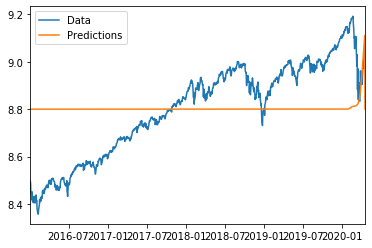

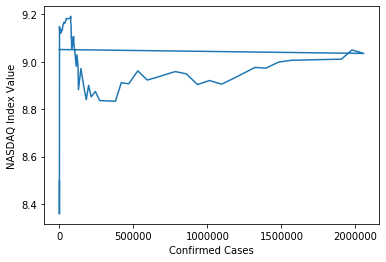

Effect of COVID-19 Deaths on the NASDAQ
	R^2:  0.01199920389487219 
	Intercept: 8.800737759028497 
	Slope:           0
0  0.000002


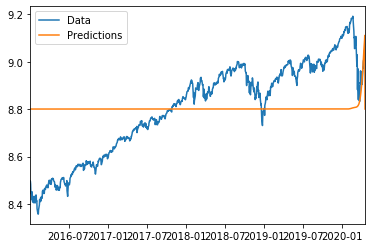

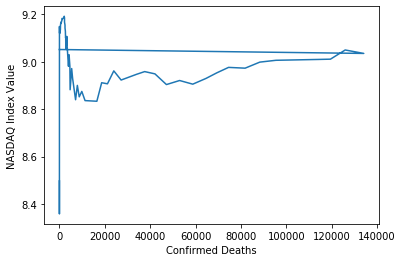

Effect of COVID-19 cases on # of publications
	R^2:  0.8654485425530029 
	Intercept: 19.211148040273976 
	Slope:           0
0  0.002312


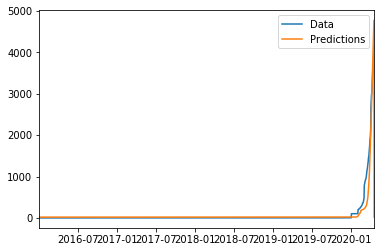

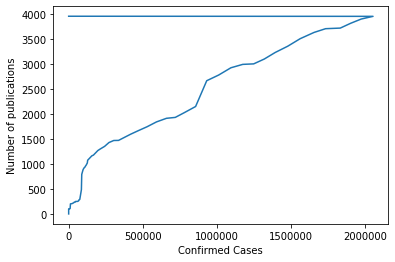

Effect of COVID-19 deaths on # of publications
	R^2:  0.8169451628841771 
	Intercept: 25.13980325591072 
	Slope:           0
0  0.037822


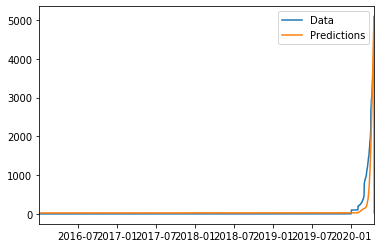

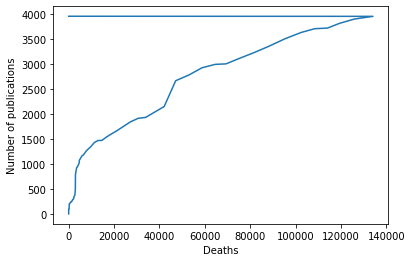

Confirmed cases + Confirmed Deaths combined effects on # of publications
	R^2:  0.9090963502083879 
	Intercept: 9.574202325438364 
	Slope:           0
0  0.007330
1 -0.084937


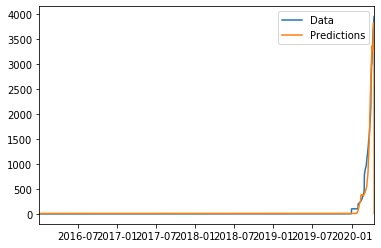

Effect of stock market on # of publications
	R^2:  0.02586888497656392 
	Intercept: -2737.5523071468974 
	Slope:             0
0  318.686906


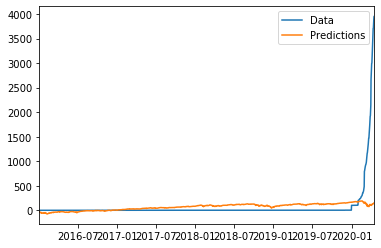

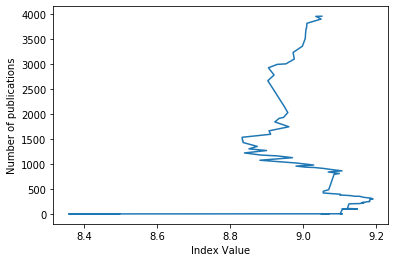

Stock market + Confirmed cases + Confirmed Deaths combined effects on # of publications
	R^2:  0.8678506976149639 
	Intercept: -841.6790099560277 
	Slope:            0
0   0.002297
1  97.826563


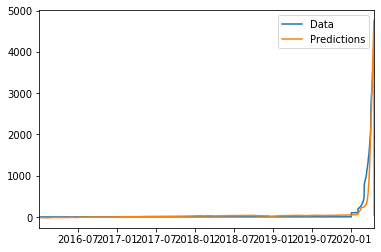

In [2]:
import os

slash = os.path.sep
ebsco_path = "ebsco_pubs"+slash+"rawData.xml"
jhu_path = "jhu_covid19"+slash+"COVID-19"+slash+"csse_covid_19_data"+slash+"csse_covid_19_time_series"+slash
quandl_key = "ksramtjbK7R5TQm9NyDs"

covid, pubs, stocks = read_data(ebsco_abs_path=ebsco_path, jhu_dir_path=jhu_path, quandl_api_key=quandl_key)

# Get the data into one dataframe
pool = pool_data(covid=covid, 
                 pubs=pubs,
                 stocks=stocks,
                normalized=False)
dummies = pd.get_dummies(data = pool.index)
dummies.index = pool.index
frames = [pool, dummies]
pool = pd.concat(frames, axis = 1, sort=True)

# Don't use today's data, we can't get stock data from today
pool = pool[:-1]
#plot_data(covid, pubs, stocks, pool)

# Make a linear regression:
# https://realpython.com/linear-regression-in-python/
# https://scikit-learn.org/stable/modules/linear_model.html

print("Models:")
dummies = None
covidVnsdq(pool, dummies)

covidVpubs(pool, dummies)

nsdqVpubs(pool, dummies)

nsdqNcovidVpubs(pool, dummies)
